In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1i6CoysSUSVXbGLbgQOieLZj-Eq7UCnqC')

     |████████████████████████████████| 71kB 3.3MB/s 


In [ ]:
# import all necessary libaries
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
# name of the project
project_name='project-food-classification-resnet'

This machine learning project is a classification problem which can classify between 6 differnt types of common Nigerian dishes namely: pounded_yam, moimoi, akara_balls, amala_and_ewedu, fried_rice and jollof_rice. I actually aim to help tourists and foreigners navigate the country's dishes easily. The images are google images with 35 samples of each food.

5 of each class will be used for validation and the remaining for training.

In [ ]:
# the dataset is in a google drive, so I have to mount it to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data directory
data_dir = './drive/MyDrive/food'

# printing the content of directory and class names which are the names of the folders
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['train', 'test']
['pounded_yam', 'moimoi', 'akara_balls', 'amala_and_ewedu', 'fried_rice', 'jollof_rice']


The dataset has different sizes of images and we need to make them of the same size. I showed some various transformations I used such as Random Rotation, Random Resizing, Horizontal Filliping, cropping, and normalization. To normalize the data, I need the mean and standard deviation for each channel i.e Red, Green and Blue colour channels for each image.

In [ ]:
# various transformations used for resizing
train_transforms = tt.Compose([
                                tt.RandomRotation(30),
                                tt.RandomResizedCrop(224),
                                tt.RandomHorizontalFlip(),
                                tt.ToTensor()])
test_transforms = tt.Compose([tt.Resize(255),
                                      tt.CenterCrop(224),
                                      tt.ToTensor()])

# importing the dataset from the directory and applying various transformation processes to it
train_data = ImageFolder(data_dir + '/train', transform=train_transforms)                                       
test_data = ImageFolder(data_dir + '/test', transform=test_transforms)

In [ ]:
# a function to display images and various labels
def show_example(img, label):
    print('Label: ', train_data.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  akara_balls (0)


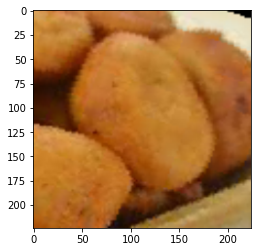

In [ ]:
show_example(*train_data[0])

Label:  pounded_yam (5)


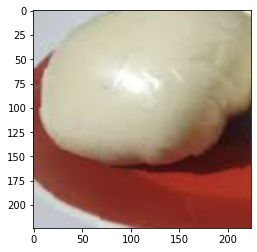

In [ ]:
show_example(*train_data[150])

Label:  amala_and_ewedu (1)


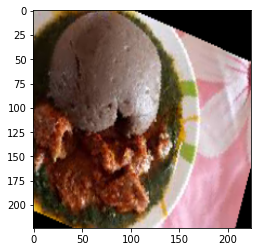

In [ ]:
show_example(*train_data[50])

Label:  pounded_yam (5)


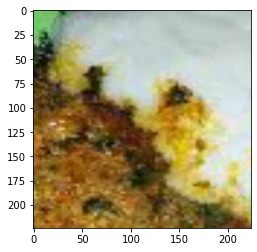

In [ ]:
show_example(*train_data[170])

Label:  moimoi (4)


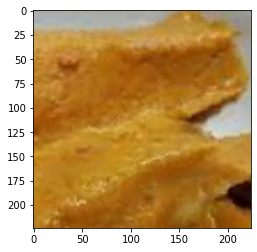

In [ ]:
show_example(*train_data[138])

Label:  fried_rice (2)


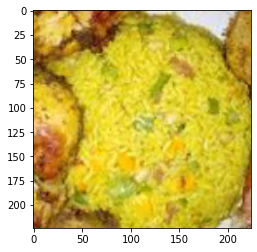

In [ ]:
show_example(*train_data[79])

Label:  jollof_rice (3)


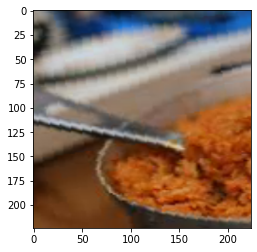

In [ ]:
show_example(*train_data[108])

In [ ]:
# now, I need to get the stats for this dataset in order for me to normalise it. stats means the mean and standard deviation for each Red, Green and Blue channel.

loader = DataLoader(train_data, batch_size=len(train_data), num_workers=1)

nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(loader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)

mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

tensor([0.6285, 0.4657, 0.2976])
tensor([0.2276, 0.2276, 0.2454])


In [ ]:
# Let's remove these variables from the memory

del train_data, test_data, loader, train_transforms, test_transforms, nimages, mean, var, std, batch

In [ ]:
# Data transforms (normalization & data augmentation)
# the stats contain the mean on the left and standard deviation on the right

stats = ((0.6268, 0.4629, 0.2863), (0.2252, 0.2231, 0.2394))
train_tfms = tt.Compose([tt.RandomRotation(30),
                         tt.RandomResizedCrop(224),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([
                         tt.Resize(255),
                         tt.CenterCrop(180),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])

In [ ]:
# lets get the datasets loaded again
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [ ]:
# let's get the batch size to load the images
batch_size = 3

In [ ]:
# PyTorch Data Loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# To denormalise data else the images will look very differently from the original
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [ ]:
# to use gpu, we need to forst have selected gpu as an accelerator from notebook settings, 
# then we need to check if indeed we are using gpu by checking the defalut device using this function
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# after, we move the data to the device    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# getting the default device
device = get_default_device()
device

device(type='cuda')

In [ ]:
# moving data to gpu
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
# defining metric to be used for evaluation
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# creating a base model for classification
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

Now, this architecture has various aspect:

* The convolution block
* resnet block
* the output block

The convolution block contains conv2d, batch normalization and relu function.

The resnet block contains two convolution blocks and the input added to it. The model has two resent blocks with two convolution blocks in between.

The output block contains maxpool, flatten, dropout and linear function.

In [ ]:
# now, we define the convolution layer containing the conv2d, batch normalization and relu.
# also, the maxpool is only defined in some blocks so let's add a condition for that
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

# now, we are extending the classification base model
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(22), # since the image size is3 by 224 by 224 and we need it to have just
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
# we also have to move the model to the gpu else we will get an error saying 'the float.cdua.Tensor.float input ought to be the same as float.Tensor.float weight'
# here 6 is the number of output channels(classes, because we have six different type of foods)
model = to_device(ResNet9(3, 6), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# the @torch.no_grad() before the evaluate function is to show that it should not compute any gradients during evaluation
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# get learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# definig the fit method
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.1666666567325592, 'val_loss': 1.7953630685806274}]

In [ ]:
del history, model

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
# to train the model
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00277, train_loss: 3.0033, val_loss: 3.0001, val_acc: 0.4333
Epoch [1], last_lr: 0.00758, train_loss: 4.0989, val_loss: 6.4118, val_acc: 0.2000
Epoch [2], last_lr: 0.01000, train_loss: 5.6546, val_loss: 5.6361, val_acc: 0.2667
Epoch [3], last_lr: 0.00950, train_loss: 3.8489, val_loss: 2.1869, val_acc: 0.3000
Epoch [4], last_lr: 0.00812, train_loss: 2.7006, val_loss: 2.4511, val_acc: 0.1667


In [ ]:
train_time = '47.3 s'

In [ ]:
# to plot the accuracies
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

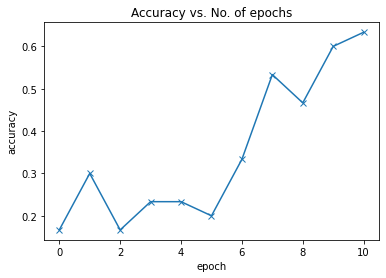

In [ ]:
plot_accuracies(history)

In [ ]:
# plotting the losses
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

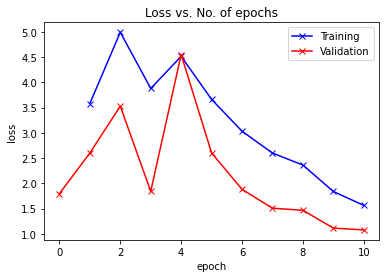

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

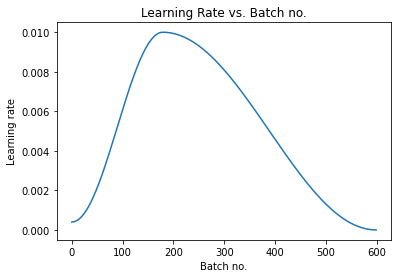

In [ ]:
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: akara_balls , Predicted: akara_balls


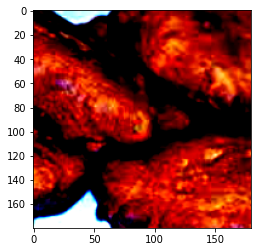

In [ ]:
img, label = valid_ds[0]
#img = denormalize(img, *stats)
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: akara_balls , Predicted: akara_balls


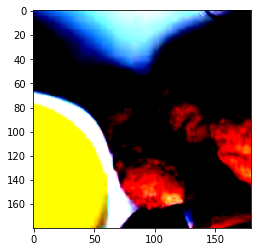

In [ ]:
img, label = valid_ds[1]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: akara_balls , Predicted: akara_balls


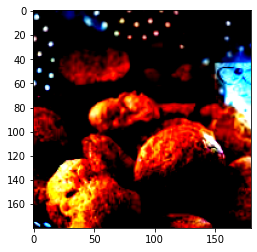

In [ ]:
img, label = valid_ds[4]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: amala_and_ewedu , Predicted: amala_and_ewedu


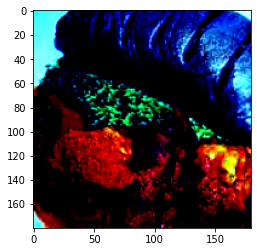

In [ ]:
img, label = valid_ds[8]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: fried_rice , Predicted: fried_rice


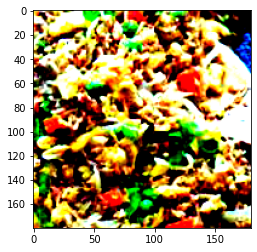

In [ ]:
img, label = valid_ds[14]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: fried_rice , Predicted: fried_rice


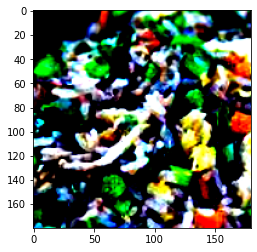

In [ ]:
img, label = valid_ds[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: jollof_rice , Predicted: akara_balls


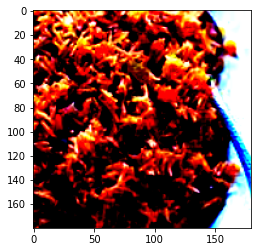

In [ ]:
img, label = valid_ds[18]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: jollof_rice , Predicted: fried_rice


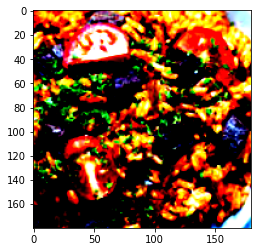

In [ ]:
img, label = valid_ds[19]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

To improve this model, more data is needed, more hyperparameter tuning and more training time

In [ ]:
# to save model using torch.save()
torch.save(model.state_dict(), 'Food-Resnet9-Model.pth')

# installing jovian so that we will upload and save the model and parameters there
!pip install jovian --upgrade --quiet
import jovian

In [ ]:
# to remove all existing parameters
jovian.reset()
# to save parameters to jovian
# you can get the api key from your profile
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
# to save the metrics to jovian
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [ ]:
# to commit it all
jovian.commit(project=project_name, environment=None, outputs=['Food-Resnet9-Model.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/akinremibunmi111/project-food-classification-resnet


'https://jovian.ai/akinremibunmi111/project-food-classification-resnet'